In [1]:
import pandas as pd
import numpy as np
import talib as ta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression


# Import

In [59]:
D = pd.read_parquet('btcusd_hourly_price_indicators.parquet', engine='pyarrow')
D

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,rsi_14,atr_7,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20
Timestamp,,,,,,,,,,,,,,,,,,,,,
2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.000000,0.000000,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 12:00:00,4.58,4.58,4.58,4.58,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 13:00:00,4.58,4.58,4.58,4.58,0.000000,0.000000,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01 14:00:00,4.58,4.58,4.58,4.58,0.000000,0.000000,0.000000,0.000000,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.00,94158.00,93600.00,94008.00,7.863550,-0.006308,0.002666,175364.391806,94342.20,94516.7,...,49.600999,787.401340,594.021005,490.327871,95801.067876,94516.7,93232.332124,95433.425204,94002.90,92572.374796
2024-12-31 20:00:00,94025.00,94059.00,93300.00,93415.00,4.565475,0.002858,-0.006308,175359.826331,93968.20,94461.6,...,42.325843,783.344006,605.805219,503.121782,95876.395307,94461.6,93046.804693,95435.711991,93998.40,92561.088009
2024-12-31 21:00:00,93386.00,93777.00,93336.00,93682.00,28.484950,-0.004142,0.002858,175388.311280,93768.80,94421.0,...,46.155291,734.437720,594.033418,500.163602,95898.271810,94421.0,92943.728190,95434.444994,94007.25,92580.055006


## Split Data for ML & DNN

In [ ]:

train = D.loc['2021-01-01':'2022-12-31']
val = D.loc['2023-01-01':'2023-12-31']
test = D.loc['2024-01-01':]

## y_train (-1, 0, 1)

In [61]:
print(train['return_forward'].min())
print(train['return_forward'].max())

-0.12395635316737363
0.12324185118729658


In [62]:
# Prediction of trading signal

y_train = pd.DataFrame(np.where(train['return_forward']>0.01, 1, np.where(train['return_forward']<-0.01, -1, 0)),
                       index=train.index,
                       columns=['y_train']
                      )

y_train

,y_train
Timestamp,
2021-01-01 00:00:00,0
2021-01-01 01:00:00,0
2021-01-01 02:00:00,0
2021-01-01 03:00:00,0
2021-01-01 04:00:00,0
...,...
2022-12-31 19:00:00,0
2022-12-31 20:00:00,0
2022-12-31 21:00:00,0


# EDA & Feature Engineering

In [63]:
train.columns

Index(['open', 'high', 'low', 'close', 'volume', 'return_forward', 'return',
       'obv', 'sma_5', 'sma_10', 'sma_20', 'sma_50', 'sma_100', 'sma_200',
       'ema_5', 'ema_10', 'ema_20', 'ema_50', 'ema_100', 'ema_200',
       'macd_12_26', 'signal_line_9', 'macd_histogram', 'adx', '+di', '-di',
       'rsi_7', 'rsi_14', 'atr_7', 'atr_14', 'atr_21', 'upper_band_10',
       'middle_band_10', 'lower_band_10', 'upper_band_20', 'middle_band_20',
       'lower_band_20'],
      dtype='object')

In [41]:
# plt.figure(figsize=(10, 10))
# plt.plot(train_data['return_forward'])

## Correlation

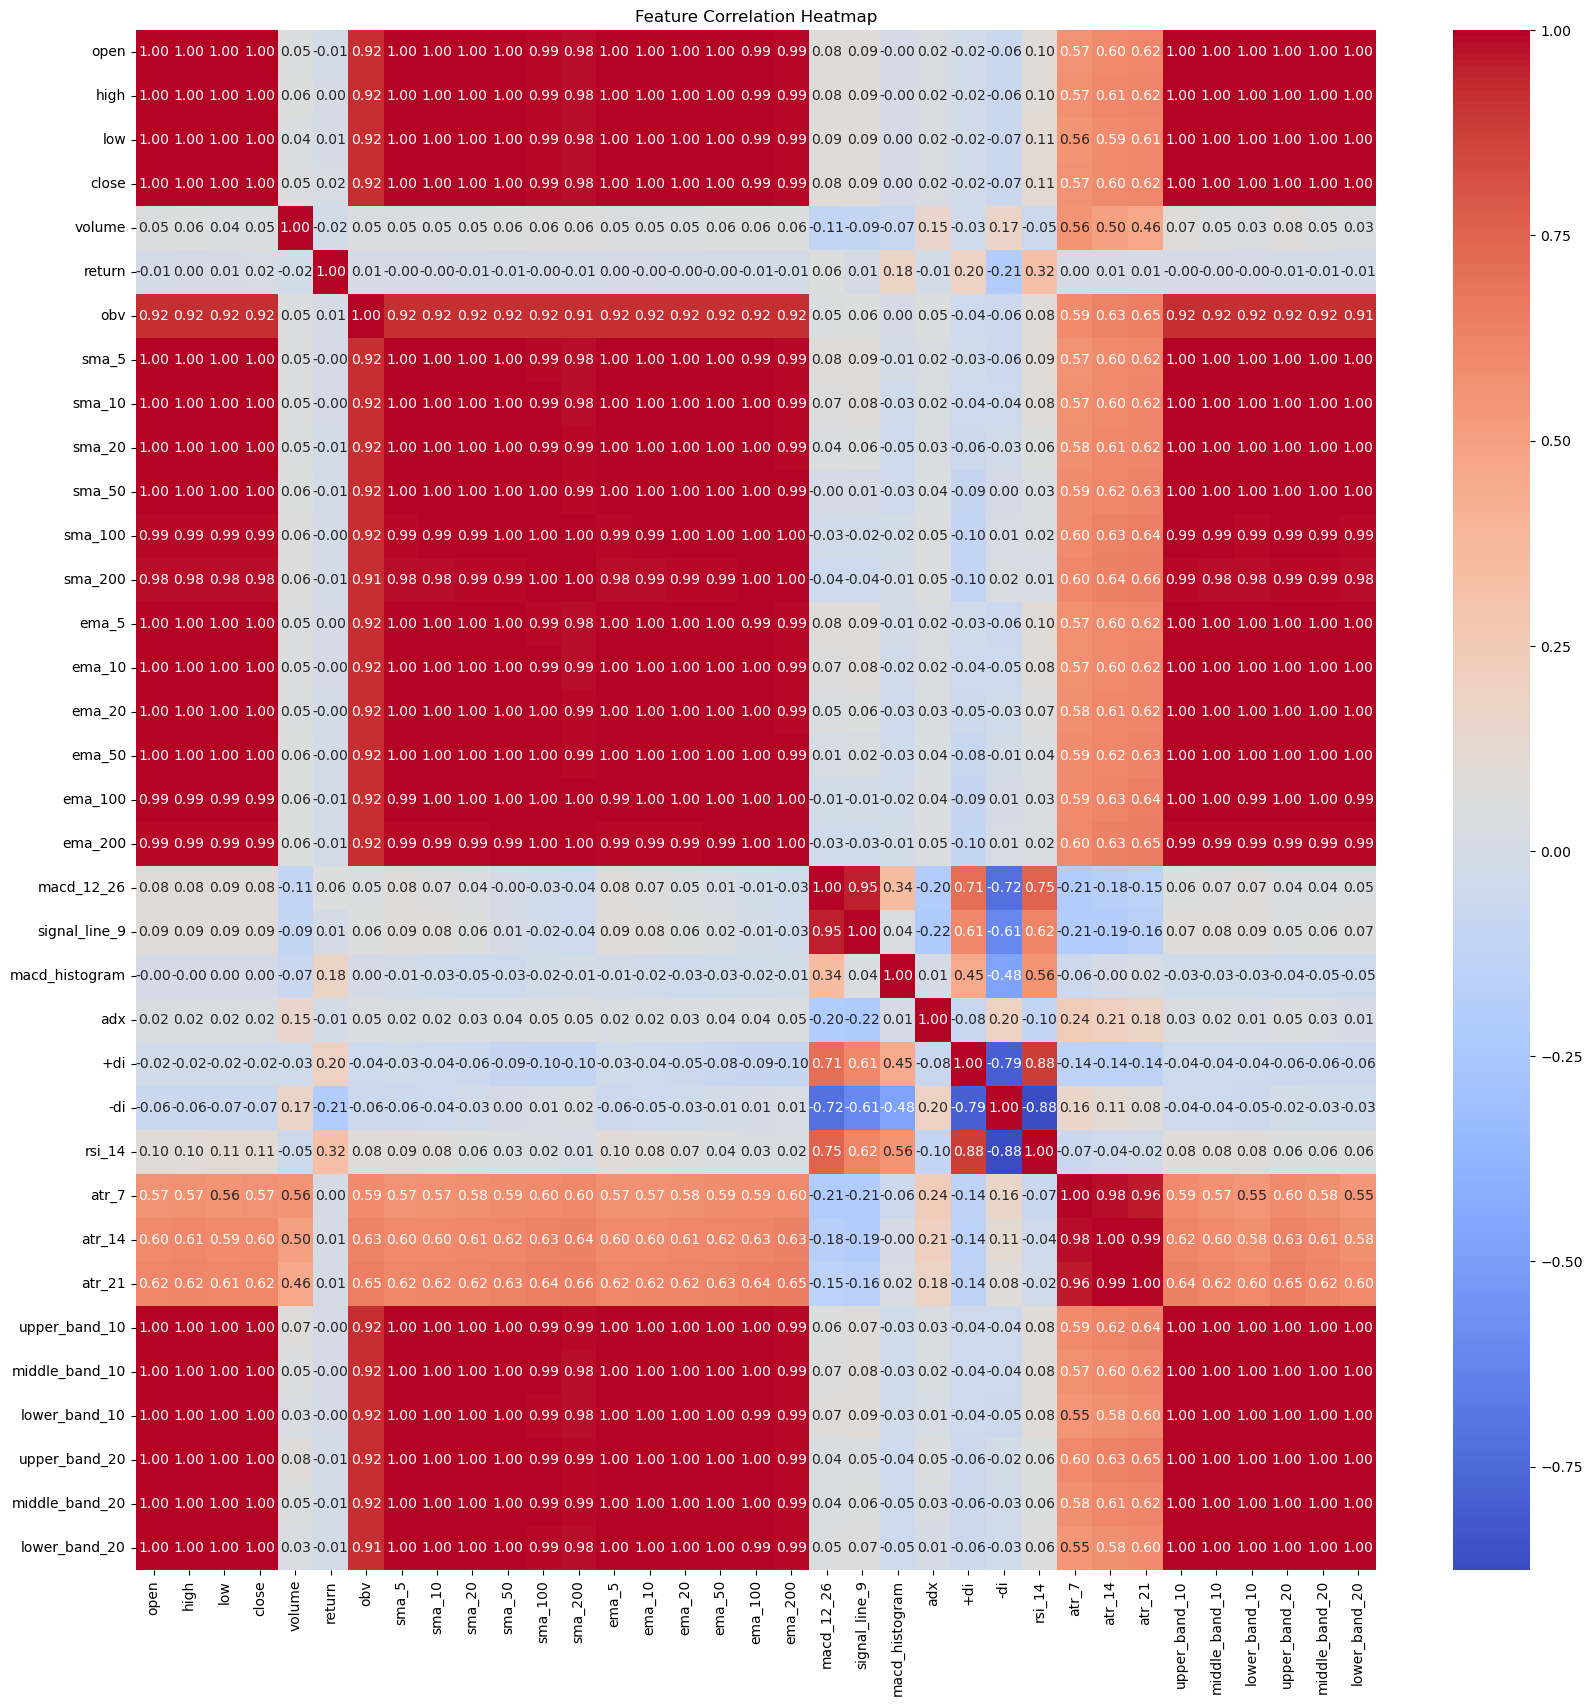

In [28]:
columns = train.drop(['return_forward'], axis=1)
corr_matrix = columns.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

## Moving Averages

In [64]:
# Manually drop some Moving Averages

train = train.drop(['sma_10','sma_100','ema_10','ema_100'], axis=1)


In [65]:
# Feature Engineering

def ma_features(df):
    val = [5,20,50,200]
    
    ma_diff = pd.DataFrame()
    
    for i in range(len(val)-1):
        short_ma = val[i]
        long_ma = val[i+1]
        ma_diff[f'sma_{short_ma}_{long_ma}_diff'] = df[f'sma_{short_ma}'] - df[f'sma_{long_ma}']
        
    for i in range(len(val)-1):
        short_ma = val[i]
        long_ma = val[i+1]
        ma_diff[f'ema_{short_ma}_{long_ma}_diff'] = df[f'ema_{short_ma}'] - df[f'ema_{long_ma}']

    for i in ma_diff:
        ma_diff[f'{i}_abs_chg'] = ma_diff[i].diff()
        ma_diff[f'{i}_pct_chg'] = ma_diff[i].pct_change()

    data = pd.concat([df[['sma_5', 'sma_20', 'sma_50', 'sma_200', 'ema_5', 'ema_20','ema_50', 'ema_200']],ma_diff], axis=1)
    return data

ma_features(train)    

,sma_5,sma_20,sma_50,sma_200,ema_5,ema_20,ema_50,ema_200,sma_5_20_diff,sma_20_50_diff,...,sma_20_50_diff_abs_chg,sma_20_50_diff_pct_chg,sma_50_200_diff_abs_chg,sma_50_200_diff_pct_chg,ema_5_20_diff_abs_chg,ema_5_20_diff_pct_chg,ema_20_50_diff_abs_chg,ema_20_50_diff_pct_chg,ema_50_200_diff_abs_chg,ema_50_200_diff_pct_chg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,28736.930,28854.8905,28299.9662,26067.8624,28789.562134,28727.375011,28307.990348,26396.228665,-117.9605,554.9243,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,28813.352,28858.0050,28352.3742,26094.6905,28925.821423,28772.228819,28342.906021,26424.110370,-44.6530,505.6308,...,-49.2935,-0.088829,25.5799,0.011460,91.405480,1.469846,9.938136,0.023697,7.033968,0.003679
2021-01-01 02:00:00,28932.070,28869.1935,28394.1632,26121.7128,28947.940949,28793.176551,28368.367746,26449.663301,62.8765,475.0303,...,-30.6005,-0.060519,14.7667,0.006541,1.171794,0.007629,-4.513993,-0.010514,-0.091207,-0.000048
2021-01-01 03:00:00,29041.018,28889.6280,28437.3836,26148.6518,29013.480632,28826.641641,28398.806658,26476.478194,151.3900,452.2444,...,-22.7859,-0.047967,16.2814,0.007165,32.074593,0.207248,3.026178,0.007124,3.624019,0.001889
2021-01-01 04:00:00,29055.380,28887.0185,28479.2488,26176.4429,29006.583755,28842.465294,28422.100122,26501.516122,168.3615,407.7697,...,-44.4747,-0.098342,14.0741,0.006149,-22.720531,-0.121605,-7.469811,-0.017460,-1.744464,-0.000907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,16572.600,16560.9000,16561.0400,16717.5350,16574.150251,16558.456335,16566.657434,16684.769180,11.7000,-0.1400,...,1.5200,-0.915663,0.7750,-0.004928,2.236068,0.166153,1.980947,-0.194553,1.720615,-0.014359
2022-12-31 20:00:00,16578.000,16563.4000,16560.5200,16716.2100,16577.433500,16560.889065,16567.337535,16683.766502,14.6000,2.8800,...,3.0200,-21.571429,0.8050,-0.005144,0.850520,0.054194,1.752629,-0.213707,1.682779,-0.014247
2022-12-31 21:00:00,16584.400,16565.1000,16559.9400,16715.0200,16582.955667,16564.042487,16568.383122,16682.873303,19.3000,5.1600,...,2.2800,0.791667,0.6100,-0.003918,2.368744,0.143175,2.107836,-0.326874,1.938786,-0.016652


## MACD

In [66]:
train[['macd_12_26', 'signal_line_9', 'macd_histogram']].tail()

,macd_12_26,signal_line_9,macd_histogram
Timestamp,,,
2022-12-31 19:00:00,6.164752,1.791878,4.372875
2022-12-31 20:00:00,7.345860,2.902674,4.443186
2022-12-31 21:00:00,8.985237,4.119187,4.866050
2022-12-31 22:00:00,8.332495,4.961848,3.370647
2022-12-31 23:00:00,7.407042,5.450887,1.956155


In [67]:
def macd_features(df):
    data = df[['macd_12_26', 'signal_line_9', 'macd_histogram']]
    data['macd_position'] = np.where(df['macd_histogram']>0, 1, -1)

    data['macd_crossover'] = np.NaN
    
    for i in range(1, len(data)):
        t = data.iloc[i,:].name
        t_1 = data.iloc[i-1,:].name

        if data.loc[t,'macd_position'] > 0 and data.loc[t_1, 'macd_position'] < 0:    
            data.loc[t,'macd_crossover'] = 1 * data.loc[t,'macd_histogram']
        if data.loc[t,'macd_position'] < 0 and data.loc[t_1, 'macd_position'] > 0:    
            data.loc[t,'macd_crossover'] = -1 * data.loc[t,'macd_histogram']
        elif data.loc[t,'macd_position'] == data.loc[t_1, 'macd_position']:
            data.loc[t, 'macd_crossover'] = 0

    
 
    return data
    
macd_features(train)

C:\Users\User\AppData\Local\Temp\ipykernel_28696\1517394548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd_position'] = np.where(df['macd_histogram']>0, 1, -1)
C:\Users\User\AppData\Local\Temp\ipykernel_28696\1517394548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd_crossover'] = np.NaN


,macd_12_26,signal_line_9,macd_histogram,macd_position,macd_crossover
Timestamp,,,,,
2021-01-01 00:00:00,109.164308,159.790918,-50.626609,-1,NaN
2021-01-01 01:00:00,135.321425,154.897019,-19.575594,-1,0.0
2021-01-01 02:00:00,137.826957,151.483007,-13.656050,-1,0.0
2021-01-01 03:00:00,150.374972,151.261400,-0.886428,-1,0.0
2021-01-01 04:00:00,146.385354,150.286191,-3.900836,-1,0.0
...,...,...,...,...,...
2022-12-31 19:00:00,6.164752,1.791878,4.372875,1,0.0
2022-12-31 20:00:00,7.345860,2.902674,4.443186,1,0.0
2022-12-31 21:00:00,8.985237,4.119187,4.866050,1,0.0


## ADX

In [68]:
train[['adx','+di','-di']].tail()

,adx,+di,-di
Timestamp,,,
2022-12-31 19:00:00,13.190243,32.968014,19.018168
2022-12-31 20:00:00,14.164779,30.665509,17.689928
2022-12-31 21:00:00,15.024477,29.111620,17.023868
2022-12-31 22:00:00,15.362844,27.475950,18.408453
2022-12-31 23:00:00,15.538319,26.603997,18.556607


In [69]:
def adx_features(df):
    data = df[['adx','+di','-di']]
    data['adx_slope'] = data['adx'].diff(3) / 3
    data['adx_strength'] = np.where(data['adx'] > 25, 1, -1)
    data['di_crossover'] = np.where(data['+di'] > data['-di'], 1, -1)
    data['di_spread'] = data['+di'] - df['-di']
    data['adx_di_composite'] = data['adx'] * data['di_spread']
    
    return data

adx_features(train)    

C:\Users\User\AppData\Local\Temp\ipykernel_28696\1819501227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['adx_slope'] = data['adx'].diff(3) / 3
C:\Users\User\AppData\Local\Temp\ipykernel_28696\1819501227.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['adx_strength'] = np.where(data['adx'] > 25, 1, -1)
C:\Users\User\AppData\Local\Temp\ipykernel_28696\1819501227.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

,adx,+di,-di,adx_slope,adx_strength,di_crossover,di_spread,adx_di_composite
Timestamp,,,,,,,,
2021-01-01 00:00:00,16.306243,20.485072,20.732451,NaN,-1,-1,-0.247380,-4.033836
2021-01-01 01:00:00,15.544151,22.077930,19.721704,NaN,-1,1,2.356225,36.625525
2021-01-01 02:00:00,14.893819,21.344246,18.761627,NaN,-1,1,2.582619,38.465053
2021-01-01 03:00:00,14.281012,20.374405,17.954142,-0.675077,-1,1,2.420263,34.563805
2021-01-01 04:00:00,13.332405,19.164867,18.785172,-0.737249,-1,1,0.379694,5.062237
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,13.190243,32.968014,19.018168,0.179997,-1,1,13.949846,184.001857
2022-12-31 20:00:00,14.164779,30.665509,17.689928,0.716660,-1,1,12.975581,183.796241
2022-12-31 21:00:00,15.024477,29.111620,17.023868,0.961245,-1,1,12.087751,181.612148


## RSI

In [83]:
def rsi_features(df):
    data = df[['rsi_7','rsi_14']]
    data['rsi_7_slope'] = data['rsi_7'].diff(3) / 3
    data['rsi_7_chg'] = data['rsi_7'].pct_change()
    data['rsi_7_acceleration'] = data['rsi_7_slope'].diff(3)
    data['rsi_14_slope'] = data['rsi_14'].diff(3) / 3
    data['rsi_14_chg'] = data['rsi_14'].pct_change()
    data['rsi_14_acceleration'] = data['rsi_14_slope'].diff(3)
    data['rsi_ratio'] = data['rsi_7'] / data['rsi_14']

    
    return data

rsi_features(train)

C:\Users\User\AppData\Local\Temp\ipykernel_28696\555473313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rsi_7_slope'] = data['rsi_7'].diff(3) / 3
C:\Users\User\AppData\Local\Temp\ipykernel_28696\555473313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rsi_7_chg'] = data['rsi_7'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_28696\555473313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

,rsi_7,rsi_14,rsi_7_slope,rsi_7_chg,rsi_7_acceleration,rsi_14_slope,rsi_14_chg,rsi_14_acceleration,rsi_ratio
Timestamp,,,,,,,,,
2021-01-01 00:00:00,57.159365,55.986099,NaN,NaN,NaN,NaN,NaN,NaN,1.020956
2021-01-01 01:00:00,64.203215,59.942816,NaN,1.232318e-01,NaN,NaN,0.070673,NaN,1.071074
2021-01-01 02:00:00,55.413387,55.499724,NaN,-1.369064e-01,NaN,NaN,-0.074122,NaN,0.998444
2021-01-01 03:00:00,60.121363,57.978989,0.987333,8.496099e-02,NaN,0.664297,0.044672,NaN,1.036951
2021-01-01 04:00:00,53.550828,54.709601,-3.550796,-1.092879e-01,NaN,-1.744405,-0.056389,NaN,0.978820
...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,62.967543,55.816082,2.349663,-6.226457e-02,0.038389,1.220820,-0.024263,0.322398,1.128125
2022-12-31 20:00:00,62.967543,55.816082,1.170156,-2.220446e-16,-4.035653,0.726864,0.000000,-1.361601,1.128125
2022-12-31 21:00:00,67.550922,57.795417,0.134135,7.278954e-02,-4.329912,0.197134,0.035462,-1.787754,1.168794


## ATR

In [71]:
train = train.drop(['atr_21'], axis=1)

In [76]:
def atr_features(df):
    data = train[['atr_7', 'atr_14']]

    data['atr_7_slope'] = data['atr_7'].diff(3) / 3
    data['atr_7_chg'] = data['atr_7'].pct_change()
    data['atr_14_slope'] = data['atr_14'].diff(3) / 3
    data['atr_14_chg'] = data['atr_14'].pct_change()
    data['price_change'] = df['close'].diff(1)
    data['norm_price_change_7'] = data['price_change'] / data['atr_7']
    data['norm_price_change_14'] = data['price_change'] / data['atr_14']
    data['atr_ratio'] = data['atr_7']/ data['atr_14']

    data['trailing_stop_long_7'] = df['high'] - 2 * df['atr_7']
    data['trailing_stop_long_14'] = df['high'] - 2 * df['atr_14']
    data['trailing_stop_short_7'] = df['low'] + 2 * df['atr_7']
    data['trailing_stop_short_14'] = df['low'] + 2 * df['atr_14']
    data.drop(['price_change'], axis=1, inplace=True)
    return data

atr_features(train)

C:\Users\User\AppData\Local\Temp\ipykernel_28696\3019256585.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['atr_7_slope'] = data['atr_7'].diff(3) / 3
C:\Users\User\AppData\Local\Temp\ipykernel_28696\3019256585.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['atr_7_chg'] = data['atr_7'].pct_change()
C:\Users\User\AppData\Local\Temp\ipykernel_28696\3019256585.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,atr_7,atr_14,atr_7_slope,atr_7_chg,atr_14_slope,atr_14_chg,norm_price_change_7,norm_price_change_14,atr_ratio,trailing_stop_long_7,trailing_stop_long_14,trailing_stop_short_7,trailing_stop_short_14
Timestamp,,,,,,,,,,,,,
2021-01-01 00:00:00,422.886222,417.797020,NaN,NaN,NaN,NaN,NaN,NaN,1.012181,28206.257556,28216.435961,29621.942444,29611.764039
2021-01-01 01:00:00,402.239619,407.837232,NaN,-0.048823,NaN,-0.023839,0.619805,0.611298,0.986275,28395.520762,28384.325535,29726.119238,29737.314465
2021-01-01 02:00:00,383.535388,398.085287,NaN,-0.046500,NaN,-0.023911,-0.537525,-0.517879,0.963450,28451.939225,28422.839425,29714.770775,29743.870575
2021-01-01 03:00:00,363.936047,387.246338,-19.650059,-0.051102,-10.183560,-0.027228,0.418700,0.393496,0.939805,28463.727907,28417.107324,29673.132093,29719.752676
2021-01-01 04:00:00,357.333754,382.280171,-14.968622,-0.018141,-8.519020,-0.012824,-0.424729,-0.397012,0.934743,28446.792492,28396.899658,29558.407508,29608.300342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,27.282350,31.759076,1.478613,0.203842,0.175358,0.059649,-0.219922,-0.188922,0.859041,16572.435300,16563.481847,16626.564700,16635.518153
2022-12-31 20:00:00,27.813443,31.704857,1.791192,0.019467,0.424737,-0.001707,0.000000,0.000000,0.877261,16556.373114,16548.590287,16636.626886,16644.409713
2022-12-31 21:00:00,26.982951,31.011653,1.440070,-0.029859,0.346780,-0.021864,0.370604,0.322459,0.870091,16548.034098,16539.976695,16633.965902,16642.023305


## Bollinger Bands

In [78]:
def bb_features(df):
    data = df[['upper_band_10', 'middle_band_10', 'lower_band_10', 'upper_band_20','middle_band_20', 'lower_band_20']]

    data['10_band_width'] = (df['upper_band_10'] - df['lower_band_10']) / df['middle_band_10']
    data['pct_b_10'] = (df['close'] - df['lower_band_10']) / (df['upper_band_10'] - df['lower_band_10'])
    
    data['20_band_width'] = (df['upper_band_20'] - df['lower_band_20']) / df['middle_band_20']
    data['pct_b_20'] = (df['close'] - df['lower_band_20']) / (df['upper_band_20'] - df['lower_band_20'])
    
    
    return data

bb_features(train)

,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20
Timestamp,,,,,,
2021-01-01 00:00:00,29223.387286,28741.153,28258.918714,29307.198761,28854.8905,28402.582239
2021-01-01 01:00:00,29240.874492,28744.982,28249.089508,29318.792740,28858.0050,28397.217260
2021-01-01 02:00:00,29256.754515,28750.826,28244.897485,29331.599971,28869.1935,28406.787029
2021-01-01 03:00:00,29351.781840,28798.405,28245.028160,29362.660536,28889.6280,28416.595464
2021-01-01 04:00:00,29380.790455,28842.084,28303.377545,29357.161215,28887.0185,28416.875785
...,...,...,...,...,...,...
2022-12-31 19:00:00,16594.849155,16557.800,16520.750845,16598.577050,16560.9000,16523.222950
2022-12-31 20:00:00,16598.916106,16562.900,16526.883894,16600.231509,16563.4000,16526.568491
2022-12-31 21:00:00,16604.931629,16568.400,16531.868371,16604.214704,16565.1000,16525.985296


# Variables & Functions for Feature Engineering & Data Transformation

In [ ]:
# one function in each markdown
# function input : dataset btcusd_hourly_price_indicators.parquet

# each function return a DataFrame for the indicator
# concat all function output to get full Dataset
# Used the dataset train as example

In [85]:
def get_features(df):
    
    def ma_features(df):
        val = [5,20,50,200]
        
        ma_diff = pd.DataFrame()
        
        for i in range(len(val)-1):
            short_ma = val[i]
            long_ma = val[i+1]
            ma_diff[f'sma_{short_ma}_{long_ma}_diff'] = df[f'sma_{short_ma}'] - df[f'sma_{long_ma}']
            
        for i in range(len(val)-1):
            short_ma = val[i]
            long_ma = val[i+1]
            ma_diff[f'ema_{short_ma}_{long_ma}_diff'] = df[f'ema_{short_ma}'] - df[f'ema_{long_ma}']
    
        for i in ma_diff:
            ma_diff[f'{i}_abs_chg'] = ma_diff[i].diff()
            ma_diff[f'{i}_pct_chg'] = ma_diff[i].pct_change()
    
        data = pd.concat([df[['sma_5', 'sma_20', 'sma_50', 'sma_200', 'ema_5', 'ema_20','ema_50', 'ema_200']],ma_diff], axis=1)
        return data


    
    def macd_features(df):
        data = df[['macd_12_26', 'signal_line_9', 'macd_histogram']]
        data['macd_position'] = np.where(df['macd_histogram']>0, 1, -1)
        data['macd_crossover'] = np.NaN
        
        for i in range(1, len(data)):
            t = data.iloc[i,:].name
            t_1 = data.iloc[i-1,:].name
    
            if data.loc[t,'macd_position'] > 0 and data.loc[t_1, 'macd_position'] < 0:    
                data.loc[t,'macd_crossover'] = 1 * data.loc[t,'macd_histogram']
            if data.loc[t,'macd_position'] < 0 and data.loc[t_1, 'macd_position'] > 0:    
                data.loc[t,'macd_crossover'] = -1 * data.loc[t,'macd_histogram']
            elif data.loc[t,'macd_position'] == data.loc[t_1, 'macd_position']:
                data.loc[t, 'macd_crossover'] = 0
        return data


    def adx_features(df):
        data = df[['adx','+di','-di']]
        data['adx_slope'] = data['adx'].diff(3) / 3
        data['adx_strength'] = np.where(data['adx'] > 25, 1, -1)
        data['di_crossover'] = np.where(data['+di'] > data['-di'], 1, -1)
        data['di_spread'] = data['+di'] - df['-di']
        data['adx_di_composite'] = data['adx'] * data['di_spread']
        return data



    def rsi_features(df):
        data = df[['rsi_7','rsi_14']]
        data['rsi_7_slope'] = data['rsi_7'].diff(3) / 3
        data['rsi_7_chg'] = data['rsi_7'].pct_change()
        data['rsi_7_acceleration'] = data['rsi_7_slope'].diff(3)
        data['rsi_14_slope'] = data['rsi_14'].diff(3) / 3
        data['rsi_14_chg'] = data['rsi_14'].pct_change()
        data['rsi_14_acceleration'] = data['rsi_14_slope'].diff(3)
        data['rsi_ratio'] = data['rsi_7'] / data['rsi_14']    
        return data


    def atr_features(df):
        data = train[['atr_7', 'atr_14']]
    
        data['atr_7_slope'] = data['atr_7'].diff(3) / 3
        data['atr_7_chg'] = data['atr_7'].pct_change()
        data['atr_14_slope'] = data['atr_14'].diff(3) / 3
        data['atr_14_chg'] = data['atr_14'].pct_change()
        data['price_change'] = df['close'].diff(1)
        data['norm_price_change_7'] = data['price_change'] / data['atr_7']
        data['norm_price_change_14'] = data['price_change'] / data['atr_14']
        data['atr_ratio'] = data['atr_7']/ data['atr_14']
    
        data['trailing_stop_long_7'] = df['high'] - 2 * df['atr_7']
        data['trailing_stop_long_14'] = df['high'] - 2 * df['atr_14']
        data['trailing_stop_short_7'] = df['low'] + 2 * df['atr_7']
        data['trailing_stop_short_14'] = df['low'] + 2 * df['atr_14']
        data.drop(['price_change'], axis=1, inplace=True)
        return data



    def bb_features(df):
        data = df[['upper_band_10', 'middle_band_10', 'lower_band_10', 'upper_band_20','middle_band_20', 'lower_band_20']]
    
        data['10_band_width'] = (df['upper_band_10'] - df['lower_band_10']) / df['middle_band_10']
        data['pct_b_10'] = (df['close'] - df['lower_band_10']) / (df['upper_band_10'] - df['lower_band_10'])
        
        data['20_band_width'] = (df['upper_band_20'] - df['lower_band_20']) / df['middle_band_20']
        data['pct_b_20'] = (df['close'] - df['lower_band_20']) / (df['upper_band_20'] - df['lower_band_20'])
        return data



    
    ma_features = ma_features(df)
    macd_features = macd_features(df)
    adx_features = adx_features(df)
    rsi_features = rsi_features(df)
    atr_features = atr_features(df)
    bb_features = bb_features(df)

    full_data = pd.concat([ma_features,macd_features,adx_features,rsi_features,atr_features,bb_features],axis=1)
    
    return full_data

get_features(train)

C:\Users\User\AppData\Local\Temp\ipykernel_28696\2518341959.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd_position'] = np.where(df['macd_histogram']>0, 1, -1)
C:\Users\User\AppData\Local\Temp\ipykernel_28696\2518341959.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['macd_crossover'] = np.NaN
C:\Users\User\AppData\Local\Temp\ipykernel_28696\2518341959.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

,sma_5,sma_20,sma_50,sma_200,ema_5,ema_20,ema_50,ema_200,sma_5_20_diff,sma_20_50_diff,...,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20,10_band_width,pct_b_10,20_band_width,pct_b_20
Timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,28736.930,28854.8905,28299.9662,26067.8624,28789.562134,28727.375011,28307.990348,26396.228665,-117.9605,554.9243,...,29223.387286,28741.153,28258.918714,29307.198761,28854.8905,28402.582239,0.033557,0.715535,0.031351,0.604066
2021-01-01 01:00:00,28813.352,28858.0050,28352.3742,26094.6905,28925.821423,28772.228819,28342.906021,26424.110370,-44.6530,505.6308,...,29240.874492,28744.982,28249.089508,29318.792740,28858.0050,28397.217260,0.034503,0.957113,0.031935,0.869297
2021-01-01 02:00:00,28932.070,28869.1935,28394.1632,26121.7128,28947.940949,28793.176551,28368.367746,26449.663301,62.8765,475.0303,...,29256.754515,28750.826,28244.897485,29331.599971,28869.1935,28406.787029,0.035194,0.738526,0.032035,0.632985
2021-01-01 03:00:00,29041.018,28889.6280,28437.3836,26148.6518,29013.480632,28826.641641,28398.806658,26476.478194,151.3900,452.2444,...,29351.781840,28798.405,28245.028160,29362.660536,28889.6280,28416.595464,0.038431,0.812766,0.032748,0.769466
2021-01-01 04:00:00,29055.380,28887.0185,28479.2488,26176.4429,29006.583755,28842.465294,28422.100122,26501.516122,168.3615,407.7697,...,29380.790455,28842.084,28303.377545,29357.161215,28887.0185,28416.875785,0.037356,0.639878,0.032550,0.612489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,16572.600,16560.9000,16561.0400,16717.5350,16574.150251,16558.456335,16566.657434,16684.769180,11.7000,-0.1400,...,16594.849155,16557.800,16520.750845,16598.577050,16560.9000,16523.222950,0.004475,0.853584,0.004550,0.806553
2022-12-31 20:00:00,16578.000,16563.4000,16560.5200,16716.2100,16577.433500,16560.889065,16567.337535,16683.766502,14.6000,2.8800,...,16598.916106,16562.900,16526.883894,16600.231509,16563.4000,16526.568491,0.004349,0.792925,0.004447,0.779652
2022-12-31 21:00:00,16584.400,16565.1000,16559.9400,16715.0200,16582.955667,16564.042487,16568.383122,16682.873303,19.3000,5.1600,...,16604.931629,16568.400,16531.868371,16604.214704,16565.1000,16525.985296,0.004410,0.850381,0.004723,0.869426
